# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/VAE/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
#ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_types[0]}_features.pkl')
#dataloaders_dict = modeler.make_dataloader(ext_data)

In [9]:
#for sample in dataloaders_dict['train']:
#    hoge = sample['features']

## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    net = Model(in_features, mid_size, latent_size)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    num_epochs = config['param']['num_epochs']
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
                                              max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, scheduler, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [11]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

2021-04-22 01:16:22,262 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-04-22 01:16:22,263 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-22 01:16:22,299 - 00_train.py - INFO - TRAINING


use: cuda:0


2021-04-22 01:16:23,963 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 26.91it/s]
2021-04-22 01:16:24,857 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.87it/s]


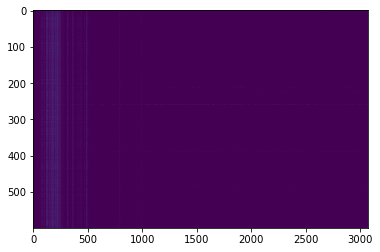

2021-04-22 01:16:25,234 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.07it/s]


,AUC,pAUC
Source_0,0.518500,0.494211
Source_1,0.400700,0.493684
Source_2,0.538100,0.504211
Target_0,0.536400,0.493158
Target_1,0.553300,0.505789
Target_2,0.489300,0.490526
mean,0.506050,0.496930
h_mean,0.500083,0.496862


2021-04-22 01:16:25,943 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:16.168389, val_AUC_hmean:0.500083, val_pAUC_hmean:0.496862, best_flag:True
2021-04-22 01:16:25,944 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 56.33it/s]
2021-04-22 01:16:26,373 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 17.98it/s]


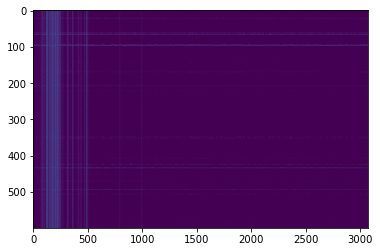

2021-04-22 01:16:26,756 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.37it/s]


,AUC,pAUC
Source_0,0.579700,0.511053
Source_1,0.436200,0.476316
Source_2,0.541900,0.506316
Target_0,0.587000,0.501579
Target_1,0.545400,0.500526
Target_2,0.515200,0.510526
mean,0.534233,0.501053
h_mean,0.529054,0.500767


2021-04-22 01:16:27,535 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:2.112687, val_AUC_hmean:0.529054, val_pAUC_hmean:0.500767, best_flag:True
2021-04-22 01:16:27,536 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 55.85it/s]
2021-04-22 01:16:27,968 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 20.04it/s]


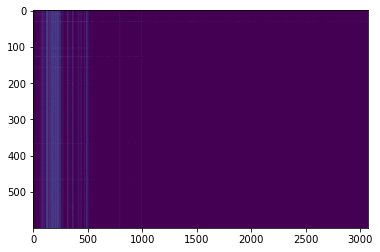

2021-04-22 01:16:28,319 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.74it/s]


,AUC,pAUC
Source_0,0.592800,0.484211
Source_1,0.519700,0.501053
Source_2,0.582600,0.492105
Target_0,0.572900,0.531053
Target_1,0.561400,0.511053
Target_2,0.590300,0.516316
mean,0.569950,0.505965
h_mean,0.568809,0.505489


2021-04-22 01:16:29,025 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:0.573876, val_AUC_hmean:0.568809, val_pAUC_hmean:0.505489, best_flag:True
2021-04-22 01:16:29,026 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 56.74it/s]
2021-04-22 01:16:29,452 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.87it/s]


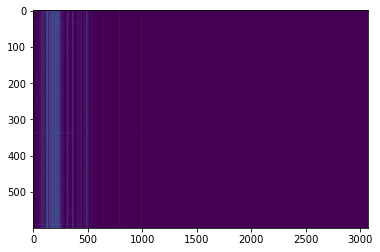

2021-04-22 01:16:29,798 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.65it/s]
2021-04-22 01:16:29,965 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:0.152660, val_AUC_hmean:0.536020, val_pAUC_hmean:0.500510, best_flag:False
2021-04-22 01:16:29,967 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 56.39it/s]
2021-04-22 01:16:30,395 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.10it/s]


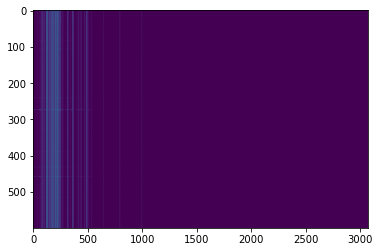

2021-04-22 01:16:30,748 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.60it/s]
2021-04-22 01:16:30,915 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:0.056691, val_AUC_hmean:0.523288, val_pAUC_hmean:0.497950, best_flag:False
2021-04-22 01:16:30,916 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 55.05it/s]
2021-04-22 01:16:31,355 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.37it/s]


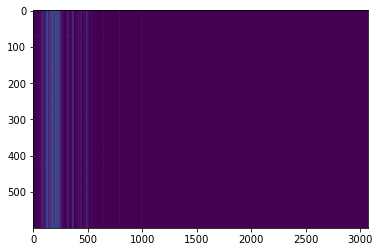

2021-04-22 01:16:31,706 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.05it/s]
2021-04-22 01:16:31,875 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:0.026769, val_AUC_hmean:0.527249, val_pAUC_hmean:0.498375, best_flag:False
2021-04-22 01:16:31,875 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.66it/s]
2021-04-22 01:16:32,294 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.77it/s]


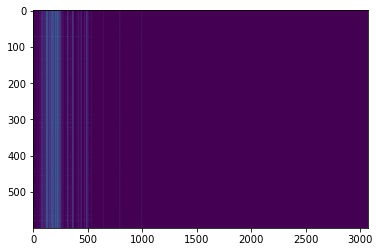

2021-04-22 01:16:32,642 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.19it/s]
2021-04-22 01:16:32,816 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:0.014298, val_AUC_hmean:0.532388, val_pAUC_hmean:0.497036, best_flag:False
2021-04-22 01:16:32,816 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.43it/s]
2021-04-22 01:16:33,237 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.66it/s]


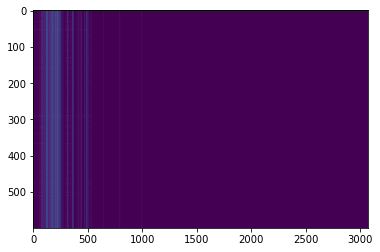

2021-04-22 01:16:33,585 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.98it/s]
2021-04-22 01:16:33,749 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:0.016061, val_AUC_hmean:0.519893, val_pAUC_hmean:0.501978, best_flag:False
2021-04-22 01:16:33,751 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 53.84it/s]
2021-04-22 01:16:34,198 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.70it/s]


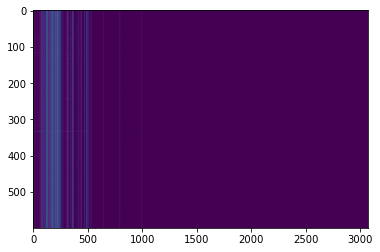

2021-04-22 01:16:34,552 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.93it/s]
2021-04-22 01:16:34,715 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:0.025642, val_AUC_hmean:0.510034, val_pAUC_hmean:0.499422, best_flag:False
2021-04-22 01:16:34,716 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.21it/s]
2021-04-22 01:16:35,138 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.72it/s]


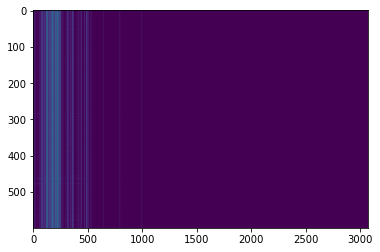

2021-04-22 01:16:35,487 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.93it/s]
2021-04-22 01:16:35,650 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:0.016652, val_AUC_hmean:0.508434, val_pAUC_hmean:0.497557, best_flag:False
2021-04-22 01:16:35,651 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 53.03it/s]
2021-04-22 01:16:36,106 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 17.86it/s]


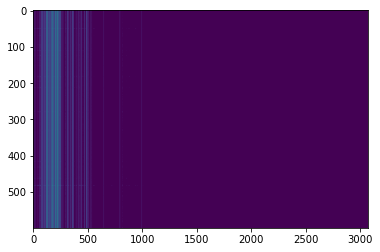

2021-04-22 01:16:36,498 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.34it/s]
2021-04-22 01:16:36,668 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:0.012075, val_AUC_hmean:0.506799, val_pAUC_hmean:0.496600, best_flag:False
2021-04-22 01:16:36,669 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 51.10it/s]
2021-04-22 01:16:37,141 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.46it/s]


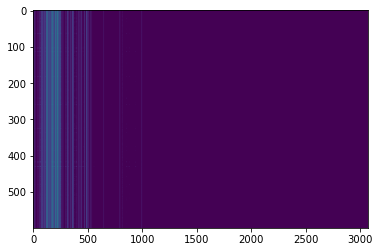

2021-04-22 01:16:37,513 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 10.11it/s]
2021-04-22 01:16:37,830 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:0.018202, val_AUC_hmean:0.495546, val_pAUC_hmean:0.495002, best_flag:False
2021-04-22 01:16:37,831 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 43.41it/s]
2021-04-22 01:16:38,387 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 10.46it/s]


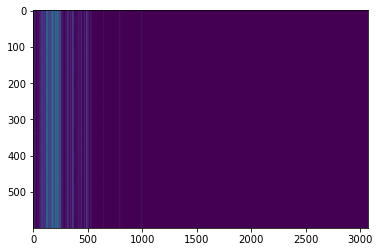

2021-04-22 01:16:38,986 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 18.42it/s]
2021-04-22 01:16:39,172 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:0.023220, val_AUC_hmean:0.506845, val_pAUC_hmean:0.499178, best_flag:False
2021-04-22 01:16:39,173 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.90it/s]
2021-04-22 01:16:39,590 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 17.47it/s]


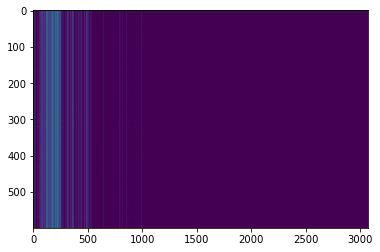

2021-04-22 01:16:39,962 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.39it/s]
2021-04-22 01:16:40,129 - pytorch_modeler.py - INFO - epoch:14/100, train_losses:0.018254, val_AUC_hmean:0.503140, val_pAUC_hmean:0.497612, best_flag:False
2021-04-22 01:16:40,130 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 56.59it/s]
2021-04-22 01:16:40,557 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.20it/s]


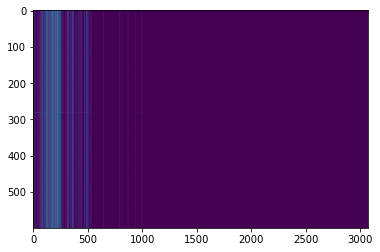

2021-04-22 01:16:40,913 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.08it/s]
2021-04-22 01:16:41,081 - pytorch_modeler.py - INFO - epoch:15/100, train_losses:0.028745, val_AUC_hmean:0.511973, val_pAUC_hmean:0.499249, best_flag:False
2021-04-22 01:16:41,082 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 55.21it/s]
2021-04-22 01:16:41,519 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.11it/s]


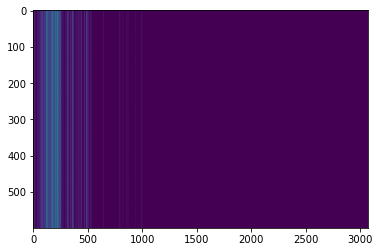

2021-04-22 01:16:41,871 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.18it/s]
2021-04-22 01:16:42,039 - pytorch_modeler.py - INFO - epoch:16/100, train_losses:0.029005, val_AUC_hmean:0.503686, val_pAUC_hmean:0.496610, best_flag:False
2021-04-22 01:16:42,040 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.13it/s]
2021-04-22 01:16:42,463 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.45it/s]


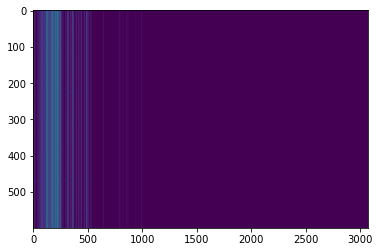

2021-04-22 01:16:42,813 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 18.26it/s]
2021-04-22 01:16:42,998 - pytorch_modeler.py - INFO - epoch:17/100, train_losses:0.017753, val_AUC_hmean:0.503468, val_pAUC_hmean:0.495985, best_flag:False
2021-04-22 01:16:42,998 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 56.61it/s]
2021-04-22 01:16:43,425 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.22it/s]


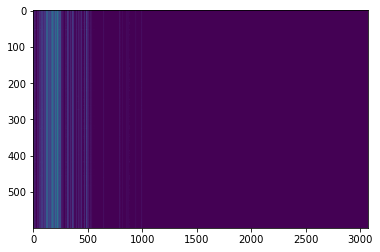

2021-04-22 01:16:43,776 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.14it/s]
2021-04-22 01:16:43,945 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:0.008671, val_AUC_hmean:0.518609, val_pAUC_hmean:0.497155, best_flag:False
2021-04-22 01:16:43,946 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 56.92it/s]
2021-04-22 01:16:44,370 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.26it/s]


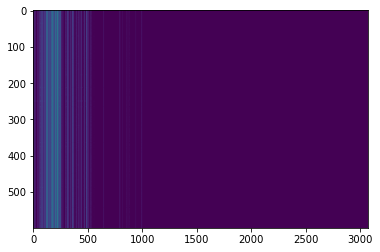

2021-04-22 01:16:44,733 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 17.95it/s]
2021-04-22 01:16:44,920 - pytorch_modeler.py - INFO - epoch:19/100, train_losses:0.067210, val_AUC_hmean:0.505485, val_pAUC_hmean:0.495566, best_flag:False
2021-04-22 01:16:44,921 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.76it/s]
2021-04-22 01:16:45,339 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.05it/s]


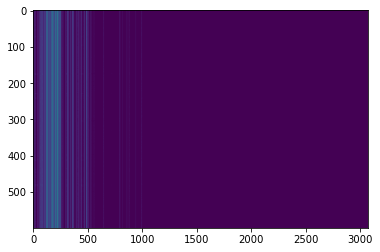

2021-04-22 01:16:45,691 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 21.00it/s]
2021-04-22 01:16:45,854 - pytorch_modeler.py - INFO - epoch:20/100, train_losses:0.032718, val_AUC_hmean:0.520411, val_pAUC_hmean:0.500877, best_flag:False
2021-04-22 01:16:45,855 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.76it/s]
2021-04-22 01:16:46,273 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.16it/s]


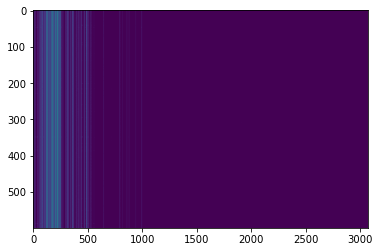

2021-04-22 01:16:46,625 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.98it/s]
2021-04-22 01:16:46,795 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:0.015067, val_AUC_hmean:0.509081, val_pAUC_hmean:0.498567, best_flag:False
2021-04-22 01:16:46,796 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 58.05it/s]
2021-04-22 01:16:47,211 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.63it/s]


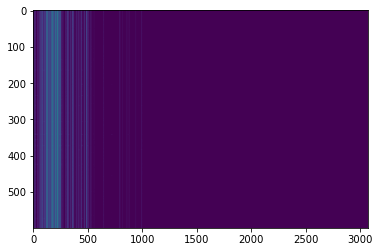

2021-04-22 01:16:47,566 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.25it/s]
2021-04-22 01:16:47,743 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:0.011819, val_AUC_hmean:0.510339, val_pAUC_hmean:0.497466, best_flag:False
2021-04-22 01:16:47,744 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 56.27it/s]
2021-04-22 01:16:48,174 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.92it/s]


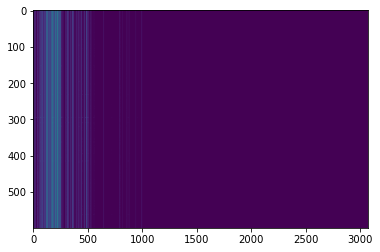

2021-04-22 01:16:48,526 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.61it/s]
2021-04-22 01:16:48,691 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:0.009657, val_AUC_hmean:0.508625, val_pAUC_hmean:0.498099, best_flag:False
2021-04-22 01:16:48,692 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 54.83it/s]
2021-04-22 01:16:49,132 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.43it/s]


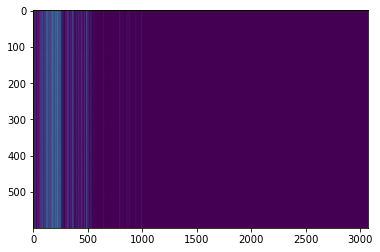

2021-04-22 01:16:49,492 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.25it/s]
2021-04-22 01:16:49,669 - pytorch_modeler.py - INFO - epoch:24/100, train_losses:0.018779, val_AUC_hmean:0.506007, val_pAUC_hmean:0.497017, best_flag:False
2021-04-22 01:16:49,670 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 55.36it/s]
2021-04-22 01:16:50,106 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.56it/s]


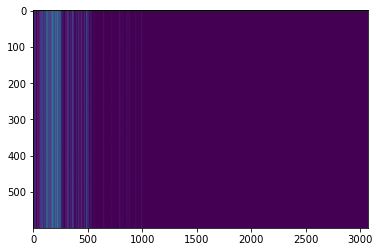

2021-04-22 01:16:50,491 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.12it/s]
2021-04-22 01:16:50,661 - pytorch_modeler.py - INFO - epoch:25/100, train_losses:0.018005, val_AUC_hmean:0.523035, val_pAUC_hmean:0.501426, best_flag:False
2021-04-22 01:16:50,662 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 58.27it/s]
2021-04-22 01:16:51,075 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.29it/s]


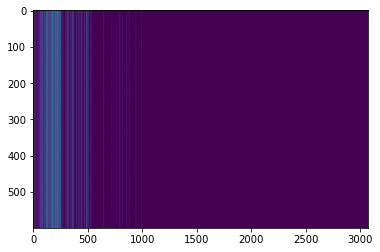

2021-04-22 01:16:51,437 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.47it/s]
2021-04-22 01:16:51,613 - pytorch_modeler.py - INFO - epoch:26/100, train_losses:0.017285, val_AUC_hmean:0.497465, val_pAUC_hmean:0.497251, best_flag:False
2021-04-22 01:16:51,614 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 59.59it/s]
2021-04-22 01:16:52,019 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.58it/s]


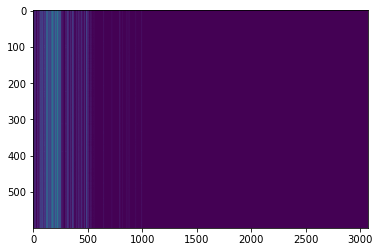

2021-04-22 01:16:52,379 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 18.74it/s]
2021-04-22 01:16:52,559 - pytorch_modeler.py - INFO - epoch:27/100, train_losses:0.060838, val_AUC_hmean:0.518256, val_pAUC_hmean:0.499530, best_flag:False
2021-04-22 01:16:52,560 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 55.34it/s]
2021-04-22 01:16:52,996 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.74it/s]


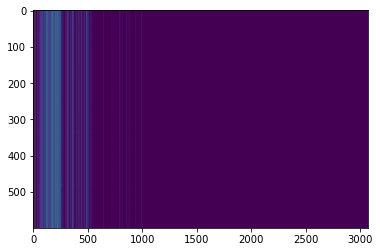

2021-04-22 01:16:53,353 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.81it/s]
2021-04-22 01:16:53,526 - pytorch_modeler.py - INFO - epoch:28/100, train_losses:0.033651, val_AUC_hmean:0.511823, val_pAUC_hmean:0.499670, best_flag:False
2021-04-22 01:16:53,527 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 55.22it/s]
2021-04-22 01:16:53,964 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 17.56it/s]


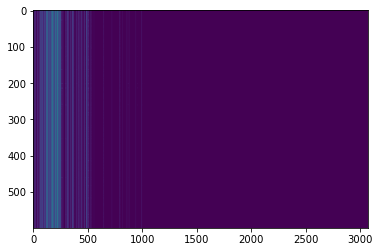

2021-04-22 01:16:54,331 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.57it/s]
2021-04-22 01:16:54,504 - pytorch_modeler.py - INFO - epoch:29/100, train_losses:0.012510, val_AUC_hmean:0.508610, val_pAUC_hmean:0.498526, best_flag:False
2021-04-22 01:16:54,505 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 55.16it/s]
2021-04-22 01:16:54,943 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 16.92it/s]


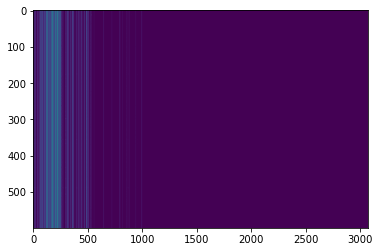

2021-04-22 01:16:55,319 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.02it/s]
2021-04-22 01:16:55,489 - pytorch_modeler.py - INFO - epoch:30/100, train_losses:0.007562, val_AUC_hmean:0.509572, val_pAUC_hmean:0.498097, best_flag:False
2021-04-22 01:16:55,490 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.36it/s]
2021-04-22 01:16:55,911 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 17.73it/s]


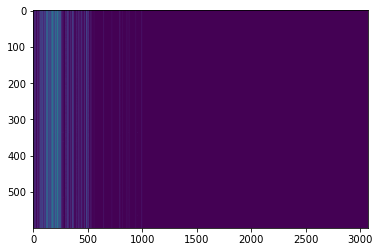

2021-04-22 01:16:56,280 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.81it/s]
2021-04-22 01:16:56,451 - pytorch_modeler.py - INFO - epoch:31/100, train_losses:0.006404, val_AUC_hmean:0.509837, val_pAUC_hmean:0.499026, best_flag:False
2021-04-22 01:16:56,452 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 58.02it/s]
2021-04-22 01:16:56,869 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 17.83it/s]


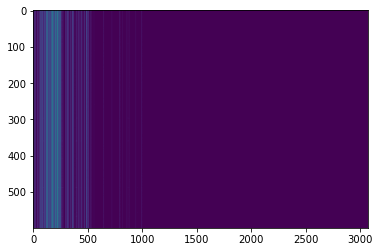

2021-04-22 01:16:57,233 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 18.71it/s]
2021-04-22 01:16:57,414 - pytorch_modeler.py - INFO - epoch:32/100, train_losses:0.090466, val_AUC_hmean:0.517086, val_pAUC_hmean:0.499399, best_flag:False
2021-04-22 01:16:57,415 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 54.50it/s]
2021-04-22 01:16:57,857 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.69it/s]


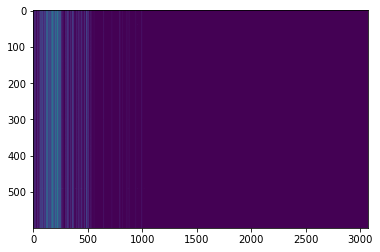

2021-04-22 01:16:58,216 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.54it/s]
2021-04-22 01:16:58,389 - pytorch_modeler.py - INFO - epoch:33/100, train_losses:0.105446, val_AUC_hmean:0.512718, val_pAUC_hmean:0.499389, best_flag:False
2021-04-22 01:16:58,390 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 56.87it/s]
2021-04-22 01:16:58,814 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.57it/s]


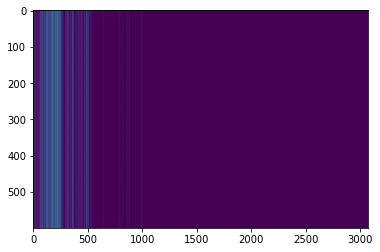

2021-04-22 01:16:59,174 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00,  9.88it/s]
2021-04-22 01:16:59,498 - pytorch_modeler.py - INFO - epoch:34/100, train_losses:0.030141, val_AUC_hmean:0.509855, val_pAUC_hmean:0.498181, best_flag:False
2021-04-22 01:16:59,499 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 42.42it/s]
2021-04-22 01:17:00,067 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00,  9.78it/s]


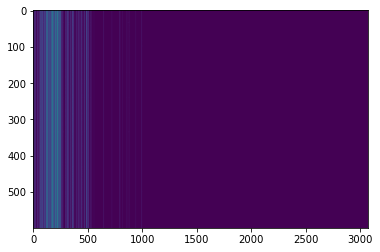

2021-04-22 01:17:00,676 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.75it/s]
2021-04-22 01:17:00,849 - pytorch_modeler.py - INFO - epoch:35/100, train_losses:0.012965, val_AUC_hmean:0.512168, val_pAUC_hmean:0.499372, best_flag:False
2021-04-22 01:17:00,850 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 54.92it/s]
2021-04-22 01:17:01,289 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.79it/s]


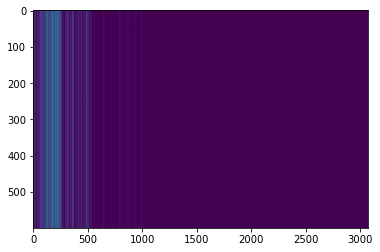

2021-04-22 01:17:01,650 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.53it/s]
2021-04-22 01:17:01,824 - pytorch_modeler.py - INFO - epoch:36/100, train_losses:0.007666, val_AUC_hmean:0.505105, val_pAUC_hmean:0.497761, best_flag:False
2021-04-22 01:17:01,825 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.95it/s]
2021-04-22 01:17:02,242 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.72it/s]


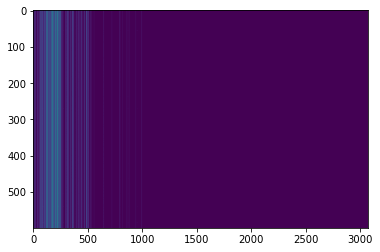

2021-04-22 01:17:02,599 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.79it/s]
2021-04-22 01:17:02,770 - pytorch_modeler.py - INFO - epoch:37/100, train_losses:0.005681, val_AUC_hmean:0.518260, val_pAUC_hmean:0.500655, best_flag:False
2021-04-22 01:17:02,771 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.94it/s]
2021-04-22 01:17:03,187 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.75it/s]


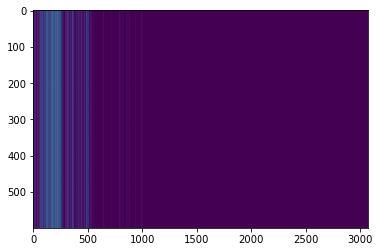

2021-04-22 01:17:03,543 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.90it/s]
2021-04-22 01:17:03,713 - pytorch_modeler.py - INFO - epoch:38/100, train_losses:0.005323, val_AUC_hmean:0.511248, val_pAUC_hmean:0.498570, best_flag:False
2021-04-22 01:17:03,714 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 54.34it/s]
2021-04-22 01:17:04,158 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.01it/s]


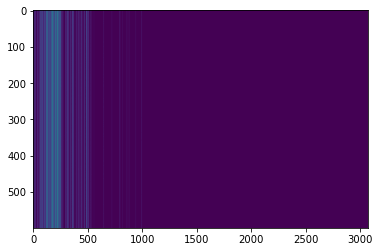

2021-04-22 01:17:04,512 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 17.97it/s]
2021-04-22 01:17:04,699 - pytorch_modeler.py - INFO - epoch:39/100, train_losses:0.005447, val_AUC_hmean:0.517606, val_pAUC_hmean:0.500161, best_flag:False
2021-04-22 01:17:04,700 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 57.11it/s]
2021-04-22 01:17:05,122 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.54it/s]


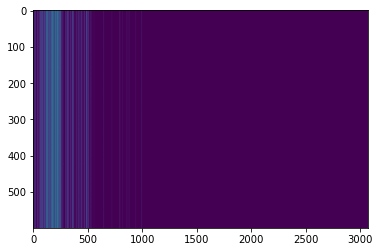

2021-04-22 01:17:05,479 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.71it/s]
2021-04-22 01:17:05,651 - pytorch_modeler.py - INFO - epoch:40/100, train_losses:0.005631, val_AUC_hmean:0.521041, val_pAUC_hmean:0.500421, best_flag:False
2021-04-22 01:17:05,652 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 53.79it/s]
2021-04-22 01:17:06,101 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 17.82it/s]


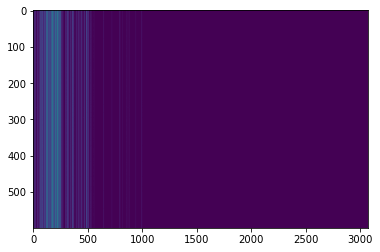

2021-04-22 01:17:06,481 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.48it/s]
2021-04-22 01:17:06,647 - pytorch_modeler.py - INFO - epoch:41/100, train_losses:0.020211, val_AUC_hmean:0.510183, val_pAUC_hmean:0.498592, best_flag:False
2021-04-22 01:17:06,648 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 56.80it/s]
2021-04-22 01:17:07,073 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.98it/s]


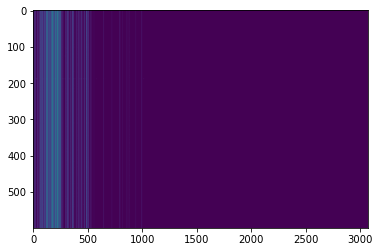

2021-04-22 01:17:07,425 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.94it/s]
2021-04-22 01:17:07,594 - pytorch_modeler.py - INFO - epoch:42/100, train_losses:0.013472, val_AUC_hmean:0.514180, val_pAUC_hmean:0.498858, best_flag:False
2021-04-22 01:17:07,595 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 59.16it/s]
2021-04-22 01:17:08,002 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 19.01it/s]


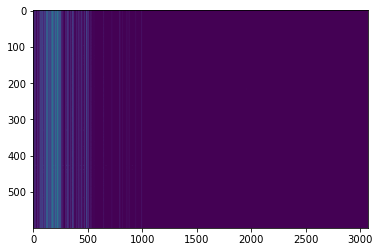

2021-04-22 01:17:08,353 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 20.44it/s]
2021-04-22 01:17:08,520 - pytorch_modeler.py - INFO - epoch:43/100, train_losses:0.011012, val_AUC_hmean:0.517988, val_pAUC_hmean:0.498614, best_flag:False
2021-04-22 01:17:08,521 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 54.42it/s]
2021-04-22 01:17:08,965 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 18.02it/s]


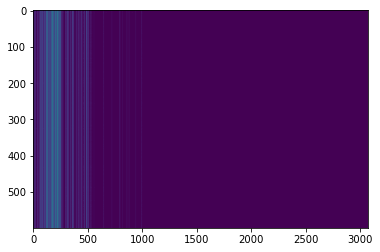

2021-04-22 01:17:09,333 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 19.26it/s]
2021-04-22 01:17:09,508 - pytorch_modeler.py - INFO - epoch:44/100, train_losses:0.012502, val_AUC_hmean:0.516447, val_pAUC_hmean:0.500472, best_flag:False
2021-04-22 01:17:09,509 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 56.23it/s]
2021-04-22 01:17:09,939 - pytorch_modeler.py - INFO - valid_source
  0%|          | 0/3 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7fa20a138c10>
Traceback (most recent call last):
  File "/home/hiroki/anaconda3/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
100%|██████████| 3/3 [00:00<00:00, 17.80it/s]


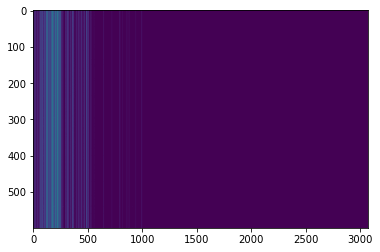

2021-04-22 01:17:10,326 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 3/3 [00:00<00:00, 17.65it/s]
2021-04-22 01:17:10,518 - pytorch_modeler.py - INFO - epoch:45/100, train_losses:0.012876, val_AUC_hmean:0.512879, val_pAUC_hmean:0.497931, best_flag:False
2021-04-22 01:17:10,519 - pytorch_modeler.py - INFO - train
100%|██████████| 24/24 [00:00<00:00, 52.10it/s]
2021-04-22 01:17:10,982 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 3/3 [00:00<00:00, 17.90it/s]


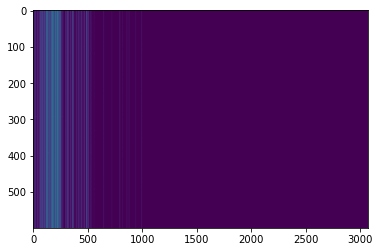

2021-04-22 01:17:11,360 - pytorch_modeler.py - INFO - valid_target
 67%|██████▋   | 2/3 [00:00<00:00, 11.91it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hiroki/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-9c47a29ad1dc>", line 2, in <module>
    run(machine_type)
  File "<ipython-input-10-ea31ac4ddece>", line 31, in run
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, scheduler, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
  File "/home/hiroki/research/dcase2021_task2/src/model_codes/ID_Conditional_VAE/VAE/pytorch_modeler.py", line 200, in train_net
    output_dict = net(input, device)
  File "/home/hiroki/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/hiroki/research/dcase2021_task2/src/model_codes/ID_Conditional_VAE/VAE/pytorch_model.py", line 106, in forward
    x = self.fc_block1(x, use_tanh=True)
  File "/home/h

TypeError: object of type 'NoneType' has no len()

In [12]:
for machine_type in machine_types:
    run(machine_type)